<a href="https://www.kaggle.com/code/keremkosif/disaster-prediction-using-nlp?scriptVersionId=97123060" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Disaster Prediction with Lemmatization and Preprocessing
In this notebook, I tried to build a model for a disaster dataset. I also used Lemmatization and Preprocessing to clean the data. This dataset includes tweets that contain information about some disasters. However, not all words are used for disaster meaning some may be used figuratively. So in This notebook, I will first preprocess the tweets, remove punctuations and stop words, transform words into paddings and finally build an LSTM model for detecting if tweets were related to a disaster.

## Import Libraries

In [1]:
from tensorflow import keras
from nltk.corpus import stopwords
import os
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy
from tqdm import tqdm
from wordcloud import WordCloud

## Importing Datasets
In this notebook my goal is prioritizing lemmatization and regular expression for preprocessing. So I will only use index and text columns of the dataset. Also null values must be 

In [2]:
df = pd.read_csv('../input/nlp-getting-started/train.csv')
#df['keyword'] = df['keyword'].fillna(0)
#df['location'] = df['location'].fillna(0)

## Starting the Preprocessing!
## Step 1 Stop Words

In [3]:
text = "".join(df["text"].to_list())
wordcloud = WordCloud().generate(text)

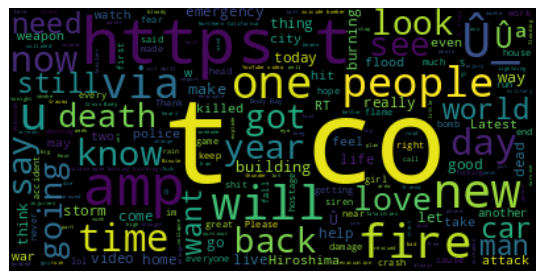

In [4]:
plt.figure(figsize=(8, 6), dpi=85)
plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")
plt.axis("off")
plt.show()

In [5]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Step2 Regular Expression

In [6]:
def create_lematized_dataset():
    lemmatizer = spacy.load('en_core_web_sm')
    description_list = []
    stop_words = set(stopwords.words("english"))
    for i in tqdm(range(df.text.shape[0])):
        clear_text = df.text[i]
        clear_text = re.sub("[^a-zA-Z]", " ", clear_text)
        clear_text = clear_text.lower()
        clear_text = nltk.word_tokenize(clear_text)
        metin = " ".join(clear_text)
        clear_text = ''.join((str(word) + ' ') for word in clear_text if not word in stopwords.words())
        clear_text = lemmatizer(clear_text)
        clear_text = " ".join([token.lemma_ for token in clear_text])
        description_list.append(clear_text)

    df['text'] = description_list
    df.to_csv('proccesed_data.csv', index=False)

In [7]:
def create_test_data():
    dfs = pd.read_csv('../input/nlp-getting-started/test.csv')

    lemmatizer = spacy.load('en_core_web_sm')
    description_list = []
    stop_words = set(stopwords.words())
    for i in tqdm(range(dfs.text.shape[0])):
        clear_text = dfs.text[i]
        clear_text = re.sub("[^a-zA-Z]", " ", clear_text)
        clear_text = clear_text.lower()
        clear_text = nltk.word_tokenize(clear_text)
        metin = " ".join(clear_text)
        clear_text = ''.join((str(word) + ' ') for word in clear_text if not word in stopwords.words())
        clear_text = lemmatizer(clear_text)
        clear_text = " ".join([token.lemma_ for token in clear_text])
        description_list.append(clear_text)

    dfs['text'] = description_list
    dfs.to_csv('proccesed_test.csv', index=False)
    
#create_test_data()

In [8]:
df2 = pd.read_csv('../input/nlp-getting-started/train.csv')
df = pd.read_csv('../input/disaster-preproccesed/proccesed_data.csv')
df['id'] = df2['id']
df = df[['id', 'keyword', 'location', 'text', 'target']]
df.dropna(inplace=True)

In [9]:
df['keyword'] = df['keyword'].fillna(0)
df['location'] = df['location'].fillna(0)

In [10]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1].values
y = np.reshape(y, (-1, 1))

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [12]:
def one_hot():
    y_train = pd.Series(y_train)
    y_valid = pd.Series(y_valid)
    from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
    y_train2 = to_categorical(y_train, num_classes = 2)
    y_valid2 = to_categorical(y_valid, num_classes = 2)
    print(y_train2)

In [13]:
vocab_size = 5000 # 18233 tane farkli kelime
embedding_dim = 16
max_length = 25
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train['text'])
word_index = tokenizer.word_index

# Train
sequences_train = tokenizer.texts_to_sequences(X_train['text'])
padded_train = pad_sequences(sequences_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Test
sequences_valid = tokenizer.texts_to_sequences(X_valid['text'])
padded_valid = pad_sequences(sequences_valid, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_valid_le = le.transform(y_valid)
# Y lerin son hali. -> Son işlem stringden integera dönüştürme.

y_train_oh = to_categorical(y_train_le, num_classes = 2)
y_valid_oh = to_categorical(y_valid_le, num_classes = 2)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [16]:
from keras import layers
emb_model = keras.models.Sequential()
emb_model.add(layers.Embedding(vocab_size, 16, input_length=max_length))
emb_model.add(layers.Bidirectional(layers.LSTM(128, dropout=0.3, recurrent_dropout=0.2)))
emb_model.add(layers.Dense(256, activation='relu'))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))

optimizer = keras.optimizers.Adam(0.0001)
emb_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [17]:
padded_train[0]

array([227,  21,   4,   2,  89,   1,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [18]:
len(padded_train)

6849

In [19]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath="", save_best_only=True, monitor='val_loss', mode='min')
#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

emb_model.fit(padded_train, y_train_oh, epochs=100, batch_size=64, verbose=2, validation_data=(padded_valid, y_valid_oh), callbacks=[earlyStopping, checkpoint]) #, reduce_lr_loss])

2022-05-31 15:24:57.250859: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
108/108 - 28s - loss: 0.6791 - accuracy: 0.5690 - val_loss: 0.6572 - val_accuracy: 0.5853


2022-05-31 15:25:28.483997: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
108/108 - 21s - loss: 0.6234 - accuracy: 0.6616 - val_loss: 0.6041 - val_accuracy: 0.7073
Epoch 3/100
108/108 - 21s - loss: 0.4954 - accuracy: 0.7737 - val_loss: 0.5089 - val_accuracy: 0.7572
Epoch 4/100
108/108 - 21s - loss: 0.4261 - accuracy: 0.8122 - val_loss: 0.4954 - val_accuracy: 0.7730
Epoch 5/100
108/108 - 21s - loss: 0.3822 - accuracy: 0.8349 - val_loss: 0.4944 - val_accuracy: 0.7756
Epoch 6/100
108/108 - 21s - loss: 0.3575 - accuracy: 0.8474 - val_loss: 0.4921 - val_accuracy: 0.7703
Epoch 7/100
108/108 - 20s - loss: 0.3323 - accuracy: 0.8552 - val_loss: 0.5068 - val_accuracy: 0.7717
Epoch 8/100
108/108 - 21s - loss: 0.3186 - accuracy: 0.8676 - val_loss: 0.5112 - val_accuracy: 0.7756
Epoch 9/100
108/108 - 21s - loss: 0.3013 - accuracy: 0.8750 - val_loss: 0.5216 - val_accuracy: 0.7730
Epoch 10/100
108/108 - 21s - loss: 0.2846 - accuracy: 0.8822 - val_loss: 0.5406 - val_accuracy: 0.7730
Epoch 11/100
108/108 - 21s - loss: 0.2713 - accuracy: 0.8921 - val_loss: 0.5466 -